# Isolating inelastic signal
    
As examples we use three OF runs [001,002,003], two 1F runs [004,005], two 2F runs [006,007], and one 3F run [008]. All obtained with solution data.

```{note}
Margaret: Under 'reducing raw data' I wonder if we could briefly dive into what an hdf5 file is/ talk about keys/groups in the file and maybe even how to list the keys in such a file? I've dealt with h5 files in the past which are kind of a mystery to me in terms of what is stored in there.... so maybe that could be useful to some people. 
```

## Create raw image

The data is loaded from the .hdf5-file, with data structure as has previously been discussed. We here use scripts which are given a beamtime-tag, such that they can easily be expanded with additional experiments. Loading the data for run #1:

In [149]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def load_runs(runs,bt):
    '''
    Load hdf5-file from runs, containing
        (x,y) coordinates of droplets [dim ndroplets]
        intensity of droplets         [dim ndroplets]
        number of droplets            [dim nshots]
        intensity of pulses           [dim nshots]
        
    Call: x,y,adi,ndrop,gmd = load_runs([run1,run2,...],bt)
    '''
    x = []; y = []; adu = []; ndrop = []; gmd = []
    for run in runs:
        if bt == 'instruction':
            fh = h5py.File('../../example_data/run-%03d.h5' %run, 'r')
            X  = fh['x'][()]; Y = fh['y'][()]; I = fh['adu'][()]
            N  = fh['ndroplets'][()]; E = fh['pulse_energy'][()]
            fh.close()
        x.append(X); y.append(Y); adu.append(I),ndrop.append(N); gmd.append(E)
    return np.concatenate(x),np.concatenate(y),np.concatenate(adu),np.concatenate(ndrop),np.concatenate(gmd)

runs              = [1]
bt                = 'instruction'
x,y,adu,ndrop,gmd = load_runs(runs,bt)

The image can be constructed directly from this data, but it may need to be corrected for the actual detector geometry in order to have the correct dimensions. Here we use a, epix100 detector, which has four tiles separated by the size equivalency of five pixels. As such, we manually insert a row and column of five empty pixels in the middle of the detector. If there is a tilt of the signal due to small rotations of some component this should also be done here.

```{note}
Imposing the correct detector is often done through geometry information from the XFEL analysis framework (*e.g.* psana for LCLS), but we here perform this manually.
```

The image is here constructed using 'np.histogram2d', which need to know the total size of the (raw) image ('bins' parameters).

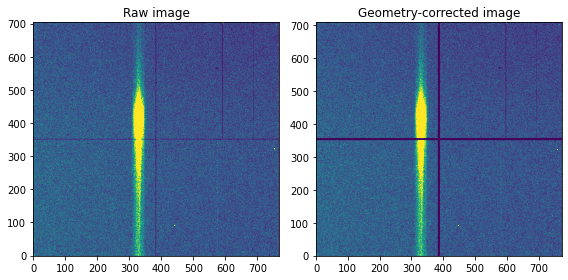

In [150]:
def det_geom(img,bt):
    '''
    Correct image for detector geometry
    '''
    if bt == 'instruction':
        new_img = [];  I = 0
        for i in np.arange(709):
            if (i > 352) and (i < 358):  new_img.append(np.zeros(len(img[0])+5))
            else:
                tmp = img[I]
                for j in np.arange(5): tmp = np.insert(tmp, 384, 0.0)
                new_img.append(tmp); I += 1
    return new_img


fig = plt.figure(figsize=(8,4))
plt.subplot(121); plt.title('Raw image')
img, xedges, yedges = np.histogram2d(x, y, bins=[np.arange(705), np.arange(769)])
# using the 1-99th percentage, i.e. avoiding the strongest and weakest 2% of the signal
vmin, vmax = np.percentile(img, [1, 99])
plt.imshow(img, origin='lower',vmin=vmin, vmax=vmax,aspect='auto')

plt.subplot(122); plt.title('Geometry-corrected image')
img, xedges, yedges = np.histogram2d(x, y, bins=[np.arange(705), np.arange(769)])
img = det_geom(img,bt)
vmin, vmax = np.percentile(img, [1, 99])
plt.imshow(img, origin='lower',vmin=vmin, vmax=vmax,aspect='auto')
plt.tight_layout(); plt.show()

## Signal sources

In order to consider only the inelastic scattering, we construct a histogram which show the occurence of different signal levels on the detector. This is here expressed in units of ADU (analog-to-digital units), as is the output from the epix100 detector, but it could equally well be expressed in units of keV.

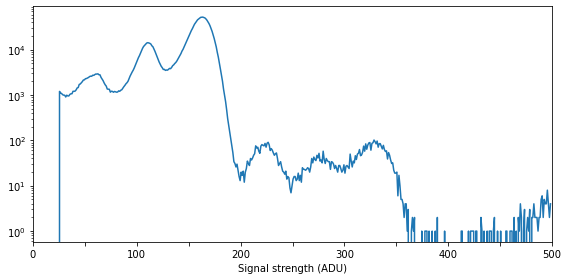

In [151]:
plt.figure(figsize=(8,4))
# Construct histogram from 0 to 500 ADU
hist, bin_edges = np.histogram(adu,bins = np.arange(0,500))
plt.plot(bin_edges[1:]-0.5,hist)
# [1:] and shift as bin_edges is not the same as bin center

# Layout
plt.xlim((0,500))
plt.xticks([0,50,100,150,200,250,300,350,400,450,500],('0','','100','','200','','300','','400','','500'))
plt.yscale('log')
plt.xlabel('Signal strength (ADU)')
plt.tight_layout(); plt.show()

The histogram is dominated by three features below 200 ADU, composing of 

1. An artifact of the detector and analysis protocol at around 60 ADU

2. The X-ray fluorescence signal at around 110 ADU

3. Elastic scattering at around 160 ADU

Higher-energy peaks at around 230, 280, and 330 ADU are multi-photon hits, featuring [2$\times$fluorecence], [fluorecence+elastic] and [2$\times$elastic], respectively. At the moment they will be ignored (as they are very weak), but multi-hits will later be included in our analysis.

Assuming the ADU to keV conversion is linear, and noting that the XFEL energy is 9.5 keV, the fluorescence signal is noted to be at around

\begin{equation}
110 \times \frac{9.5}{160} = 6.5 \textrm{ keV},
\end{equation}

*i.e.* the Mn $K \beta_{1,3}$ signal.

By comparison, the low-energy signal would be situated at around 3.6 keV. However, we attribute this signal to an artifact of the detector and analysis tools, and further note that it is relatively homogenous over the entire detector and can be ignored.

The relative homogeneity of the artifact and elastic scattering signal can be seen by plotting the image and spatial projection of three different ADU regions:

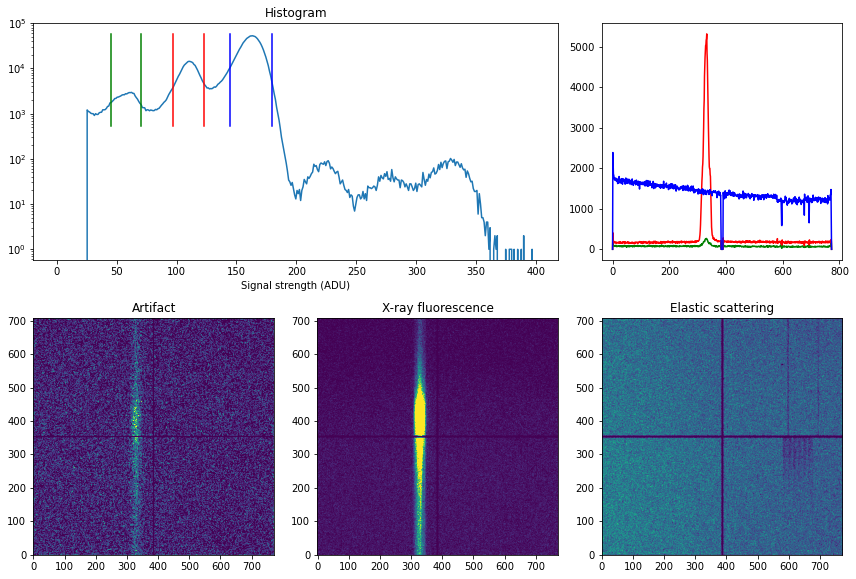

In [152]:
def create_img_v1(x,y,adu,ndrop,adu_int,scale_signal):
    '''
    Version 1 of a script which creates the full image
    
    Call: img = create_img_v1(x,y,adu,ndrop,adu_interval,scale_signal)
    '''
    ind, = np.where((adu >= adu_int[0]) & (adu <= adu_int[1]))
    if scale_signal == True:    img, xedges, yedges = np.histogram2d(x[ind], y[ind], bins=[np.arange(705), np.arange(769)],weights=adu[ind])
    elif scale_signal == False: img, xedges, yedges = np.histogram2d(x[ind], y[ind], bins=[np.arange(705), np.arange(769)])
    det_geom(img,'instruction')
    return img

# ADU regions of the three signals
adu_art = [ 45.0, 70.0]
adu_xes = [ 97.0,123.0]
adu_sca = [145.0,180.0]

plt.figure(figsize=(12,12))
plt.subplot2grid((3,3), (0, 0), colspan=2); plt.title('Histogram')
hist, bin_edges = np.histogram(adu,bins = np.arange(0,400)); plt.plot(bin_edges[1:]-0.5,hist)
ylims = [0.01*np.max(hist),1.1*np.max(hist)]
plt.plot([adu_art[0],adu_art[0]],ylims,'-',color='g');plt.plot([adu_art[1],adu_art[1]],ylims,'-',color='g')
plt.plot([adu_xes[0],adu_xes[0]],ylims,'-',color='r');plt.plot([adu_xes[1],adu_xes[1]],ylims,'-',color='r')
plt.plot([adu_sca[0],adu_sca[0]],ylims,'-',color='b');plt.plot([adu_sca[1],adu_sca[1]],ylims,'-',color='b')
plt.yscale('log'); plt.xlabel('Signal strength (ADU)')

plt.subplot(334); plt.title('Artifact')
img = create_img_v1(x,y,adu,ndrop,adu_art,False)
img = det_geom(img,bt); vmin, vmax = np.percentile(img, [1, 99])
plt.imshow(img, origin='lower',vmin=vmin, vmax=vmax,aspect='auto')
ax1 = plt.subplot(333); ax1.plot(np.sum(img, axis=0),color='g')

ax2 = plt.subplot(335); plt.title('X-ray fluorescence')
img = create_img_v1(x,y,adu,ndrop,adu_xes,False)
img = det_geom(img,bt); vmin, vmax = np.percentile(img, [1, 99])
plt.imshow(img, origin='lower',vmin=vmin, vmax=vmax,aspect='auto')
ax1.plot(np.sum(img, axis=0),color='r')

plt.subplot(336); plt.title('Elastic scattering')
img = create_img_v1(x,y,adu,ndrop,adu_sca,False)
img = det_geom(img,bt); vmin, vmax = np.percentile(img, [1, 99])
plt.imshow(img, origin='lower',vmin=vmin, vmax=vmax,aspect='auto')
ax1.plot(np.sum(img, axis=0),color='b')

plt.tight_layout(); plt.show()

From the images and spatial projection it is clear that:

1. The artifact signal is very weak and has some extra signal in the same region as the X-ray fluorescence, but this is very small and can be neglected.

2. The X-ray emission signal is well focused within a region of about 40 pixels (with 5 um per pixel this corresponds to 2 mm).

3. The elastic scattering is quite strong, but relatively homogenous over the detector with some stronger signal on the left side of the image. This is due to some differences in the shielding of the left and right sides.

In above script it can be noted that a boolean called 'scale_signal' was included, which is used to decide if the image should be constructed by scaling the droplet signals with the actual ADU signal. This is generally avoided, as the final analysis of the X-ray emission spectrum should only count the number of photons occuring at each detector position, and the relatively large variation in actual signal read-out is ignored. If, for example multi-photon hits are included by just using a lower ADU bound, the signal should be weighted by the actual signal.

```{note}
Be careful if multi-photon hits are included, as the current dropletting scheme only provides reliable reconstructed up to a certain photon density. This is further discussed elsewhere.
```

The influence of weighting can be illustrated for the three signal sources:

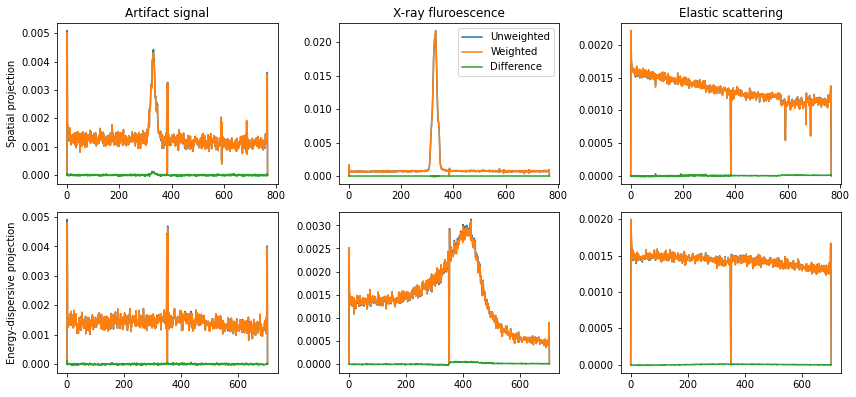

In [153]:
fig = plt.figure(figsize=(12,8))
img_raw = create_img_v1(x,y,adu,ndrop,adu_art,False); img_wei = create_img_v1(x,y,adu,ndrop,adu_art,True)
plt.subplot(331); plt.title('Artifact signal'); plt.ylabel('Spatial projection')
plt.plot(np.sum(img_raw, axis=0)/np.sum(img_raw)); plt.plot(np.sum(img_wei, axis=0)/np.sum(img_wei))
plt.plot(np.sum(img_raw, axis=0)/np.sum(img_raw)-np.sum(img_wei, axis=0)/np.sum(img_wei))

plt.subplot(334); plt.ylabel('Energy-dispersive projection')
plt.plot(np.sum(img_raw, axis=1)/np.sum(img_raw)); plt.plot(np.sum(img_wei, axis=1)/np.sum(img_wei))
plt.plot(np.sum(img_raw, axis=1)/np.sum(img_raw)-np.sum(img_wei, axis=1)/np.sum(img_wei))

img_raw = create_img_v1(x,y,adu,ndrop,adu_xes,False); img_wei = create_img_v1(x,y,adu,ndrop,adu_xes,True)
plt.subplot(332); plt.title('X-ray fluroescence')
plt.plot(np.sum(img_raw, axis=0)/np.sum(img_raw)); plt.plot(np.sum(img_wei, axis=0)/np.sum(img_wei))
plt.plot(np.sum(img_raw, axis=0)/np.sum(img_raw)-np.sum(img_wei, axis=0)/np.sum(img_wei))
plt.legend(('Unweighted','Weighted','Difference'))
plt.subplot(335)
plt.plot(np.sum(img_raw, axis=1)/np.sum(img_raw)); plt.plot(np.sum(img_wei, axis=1)/np.sum(img_wei))
plt.plot(np.sum(img_raw, axis=1)/np.sum(img_raw)-np.sum(img_wei, axis=1)/np.sum(img_wei))

img_raw = create_img_v1(x,y,adu,ndrop,adu_sca,False); img_wei = create_img_v1(x,y,adu,ndrop,adu_sca,True)
plt.subplot(333); plt.title('Elastic scattering')
plt.plot(np.sum(img_raw, axis=0)/np.sum(img_raw)); plt.plot(np.sum(img_wei, axis=0)/np.sum(img_wei))
plt.plot(np.sum(img_raw, axis=0)/np.sum(img_raw)-np.sum(img_wei, axis=0)/np.sum(img_wei))
plt.subplot(336)
plt.plot(np.sum(img_raw, axis=1)/np.sum(img_raw)); plt.plot(np.sum(img_wei, axis=1)/np.sum(img_wei))
plt.plot(np.sum(img_raw, axis=1)/np.sum(img_raw)-np.sum(img_wei, axis=1)/np.sum(img_wei))

plt.tight_layout(); plt.show()

As can be seen, even as the signal differs by a factor of about 60, 110, and 160 for the three signals the final projections are very similar. There is a small jump in the weighted energy-dispersive projection, likely due to some small residual gain difference in the different epix panels. This difference is removed when not weighting the signal, *i.e.* counting photons rather than detected signal.

## Region-of-interest (ROI) of emission signal

In order to construct the final spectra we now seek to identify the ROI of the fluorecence signal. Looking at the images and distributions above, the ROI in the spatial direction is pixel 310-348 (using the detector-corrected image), and in the energy-dispersive direction we use the full region (pixel 0-705). Note that the x-direction of the data corresponds to the energy-dispersive direction, *i.e.* vertically in the images. Constructing the ADU histogram inside the ROI and over the full detector we get:

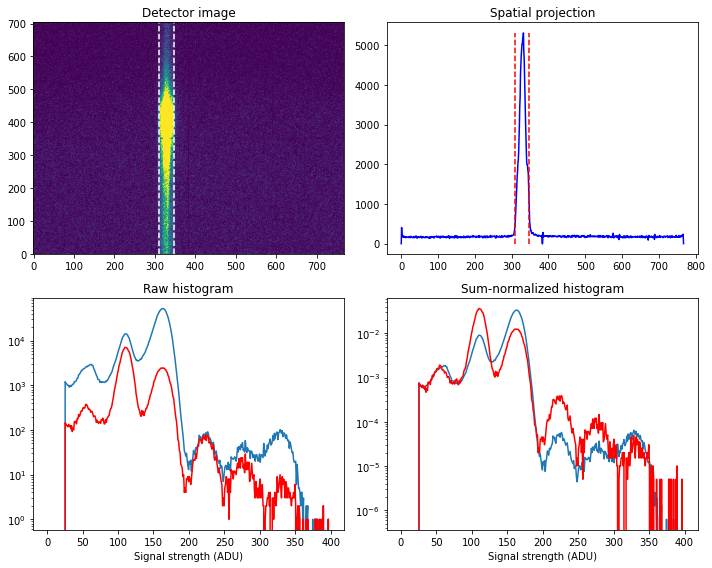

In [154]:
roi       = [0,705,310,348]
plt.figure(figsize=(10,8))
full_hist, full_bin_edges = np.histogram(adu,bins = np.arange(0,400))
# Note that this histogram is formed over the raw, and not geometry-corrected image
#  (difference is minimal)
ind, = np.where((y >= roi[2]) & (y <= roi[3]))
hist, bin_edges = np.histogram(adu[ind],bins = np.arange(0,400))

plt.subplot(221); plt.title('Detector image')
img = create_img_v1(x,y,adu,ndrop,adu_xes,False)
vmin, vmax = np.percentile(img, [1, 99])
plt.plot([roi[2],roi[2]],[roi[0],roi[1]],'w--'); plt.plot([roi[3],roi[3]],[roi[0],roi[1]],'w--')
plt.imshow(img, origin='lower',vmin=vmin, vmax=vmax,aspect='auto')

plt.subplot(222); plt.title('Spatial projection')
plt.plot(np.sum(img, axis=0),'b')
plt.plot([roi[2],roi[2]],[0,max(np.sum(img, axis=0))],'r--'); 
plt.plot([roi[3],roi[3]],[0,max(np.sum(img, axis=0))],'r--')

plt.subplot(223); plt.title('Raw histogram')
plt.plot(full_bin_edges[1:]-0.5,full_hist); plt.plot(bin_edges[1:]-0.5,hist,'r')
ylims = [0.01*np.max(full_hist),1.1*np.max(full_hist)]
plt.yscale('log'); plt.xlabel('Signal strength (ADU)')

plt.subplot(224); plt.title('Sum-normalized histogram')
plt.plot(full_bin_edges[1:]-0.5,full_hist/sum(full_hist))
plt.plot(bin_edges[1:]-0.5,hist/sum(hist),'r')
ylims = [0.01*np.max(full_hist),1.1*np.max(full_hist/sum(full_hist))]
plt.yscale('log'); plt.xlabel('Signal strength (ADU)')

plt.tight_layout(); plt.show()

It is clear that the X-ray fluorecence signal is much stronger in the ROI, and the multi-photon hits (those involving one or two fluorescence photons) is also much stronger (as expected).

## Image and projections inside ROI

We now compare the projections inside the ROI versus over the entire detector, focusing on the X-ray emission signal:

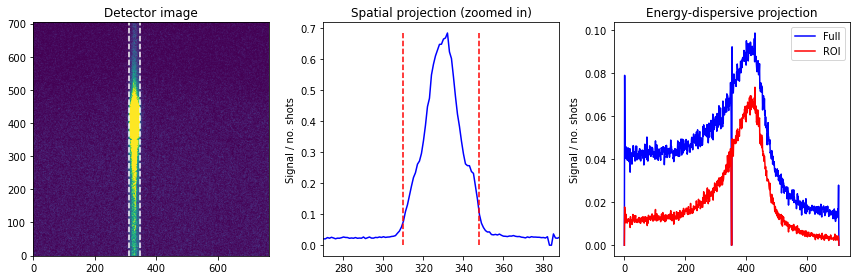

In [155]:
# Final ADU signal of the fluorecent signal
adu_int   = [97.0,123.0]

plt.figure(figsize=(12,4))
plt.subplot(131); plt.title('Detector image')
img = create_img_v1(x,y,adu,ndrop,adu_xes,False)
vmin, vmax = np.percentile(img, [1, 99])
plt.plot([roi[2],roi[2]],[roi[0],roi[1]],'w--')
plt.plot([roi[3],roi[3]],[roi[0],roi[1]],'w--')
plt.imshow(img, origin='lower',vmin=vmin, vmax=vmax,aspect='auto')

plt.subplot(132); plt.title('Spatial projection (zoomed in)')
plt.plot(np.sum(img, axis=0)/len(ndrop),'b')
plt.plot([roi[2],roi[2]],[0,max(np.sum(img, axis=0))/len(ndrop)],'r--')
plt.plot([roi[3],roi[3]],[0,max(np.sum(img, axis=0))/len(ndrop)],'r--')
plt.xlim((roi[2]-40,roi[3]+40))
plt.ylabel('Signal / no. shots')

plt.subplot(133); plt.title('Energy-dispersive projection')
plt.plot(np.sum(img, axis=1)/len(ndrop),'b')
plt.plot(np.sum(img[roi[0]:roi[1],roi[2]:roi[3]], axis=1)/len(ndrop),'r')
plt.legend(('Full','ROI'))
plt.ylabel('Signal / no. shots')

plt.tight_layout(); plt.show()

We see that the projection within the ROI is much more defined, with lower background and less noisy features (despite containing less signal).

## Influence of multi-photon hits

Here we investigate the inclusion of multi-photon hits, including

- Two XES photons

- One XES and one scattering photon

- Three XES photons

Higher multiplicities are here unlikely, and thus not included.

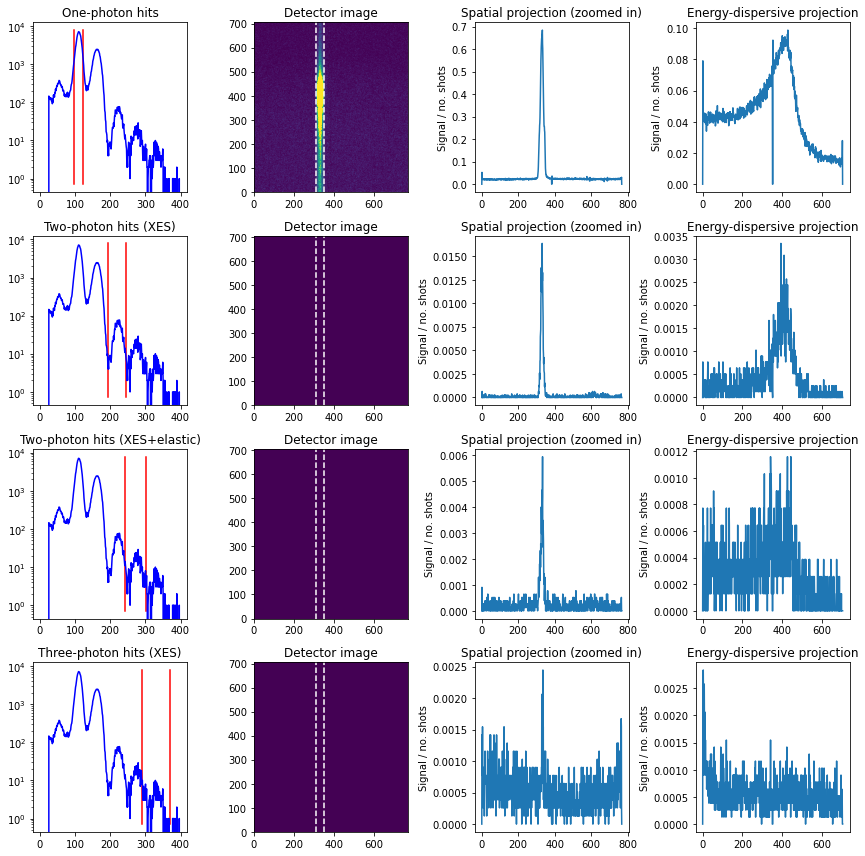

In [148]:
def multi_hit(x,y,adu,ndrop,roi,adc_int):
    img = create_img_v1(x,y,adu,ndrop,adu_int,False); vmin, vmax = np.percentile(img, [1, 99])
    plt.imshow(img, origin='lower',vmin=vmin, vmax=vmax,aspect='auto')
    plt.plot([roi[2],roi[2]],[roi[0],roi[1]],'w--');  plt.plot([roi[3],roi[3]],[roi[0],roi[1]],'w--')
    plt.ylim((roi[0],roi[1]))
    return img

plt.figure(figsize=(12,12))
plt.subplot(441); plt.title('One-photon hits')
adu_int = adu_xes
ind, = np.where((y >= roi[2]) & (y <= roi[3])); hist, bin_edges = np.histogram(adu[ind],bins = np.arange(0,400))
ylims = [0.0001*np.max(hist),1.1*np.max(hist)]
plt.plot([adu_int[0],adu_int[0]],ylims,'-',color='r'); plt.plot([adu_int[1],adu_int[1]],ylims,'-',color='r')
plt.plot(bin_edges[1:]-0.5,hist,'b'); plt.yscale('log')
plt.subplot(442); plt.title('Detector image')
img = multi_hit(x,y,adu,ndrop,roi,adu_int)
plt.subplot(443); plt.title('Spatial projection (zoomed in)')
plt.plot(np.sum(img, axis=0)/len(ndrop)); plt.ylabel('Signal / no. shots')
plt.subplot(444); plt.title('Energy-dispersive projection')
plt.plot(np.sum(img, axis=1)/len(ndrop)); plt.ylabel('Signal / no. shots')

plt.subplot(445); plt.title('Two-photon hits (XES)')
adu_int = [2.*adu_xes[0],2.*adu_xes[1]]
plt.plot([adu_int[0],adu_int[0]],ylims,'-',color='r'); plt.plot([adu_int[1],adu_int[1]],ylims,'-',color='r')
plt.plot(bin_edges[1:]-0.5,hist,'b'); plt.yscale('log')
plt.subplot(446); plt.title('Detector image')
img = multi_hit(x,y,adu,ndrop,roi,adu_int)
plt.subplot(447); plt.title('Spatial projection (zoomed in)')
plt.plot(np.sum(img, axis=0)/len(ndrop)); plt.ylabel('Signal / no. shots')
plt.subplot(448); plt.title('Energy-dispersive projection')
plt.plot(np.sum(img, axis=1)/len(ndrop)); plt.ylabel('Signal / no. shots')

plt.subplot(449); plt.title('Two-photon hits (XES+elastic)')
adu_int = [adu_xes[0]+145,adu_xes[1]+180]
plt.plot([adu_int[0],adu_int[0]],ylims,'-',color='r'); plt.plot([adu_int[1],adu_int[1]],ylims,'-',color='r')
plt.plot(bin_edges[1:]-0.5,hist,'b'); plt.yscale('log')
plt.subplot(4,4,10); plt.title('Detector image')
img = multi_hit(x,y,adu,ndrop,roi,adu_int)
plt.subplot(4,4,11); plt.title('Spatial projection (zoomed in)')
plt.plot(np.sum(img, axis=0)/len(ndrop)); plt.ylabel('Signal / no. shots')
plt.subplot(4,4,12); plt.title('Energy-dispersive projection')
plt.plot(np.sum(img, axis=1)/len(ndrop)); plt.ylabel('Signal / no. shots')

plt.subplot(4,4,13); plt.title('Three-photon hits (XES)')
adu_int = [3.*adu_xes[0],3.*adu_xes[1]]
plt.plot([adu_int[0],adu_int[0]],ylims,'-',color='r'); plt.plot([adu_int[1],adu_int[1]],ylims,'-',color='r')
plt.plot(bin_edges[1:]-0.5,hist,'b'); plt.yscale('log')
plt.subplot(4,4,14); plt.title('Detector image')
img = multi_hit(x,y,adu,ndrop,roi,adu_int)
plt.subplot(4,4,15); plt.title('Spatial projection (zoomed in)')
plt.plot(np.sum(img, axis=0)/len(ndrop)); plt.ylabel('Signal / no. shots')
plt.subplot(4,4,16); plt.title('Energy-dispersive projection')
plt.plot(np.sum(img, axis=1)/len(ndrop)); plt.ylabel('Signal / no. shots')

plt.tight_layout(); plt.show()

We see that there is some influence of two-photon hits, primarily involving two X-ray emission photons. As such, we form a new create_img function and show the difference between including only one-photon and both one- and two-photon hits.

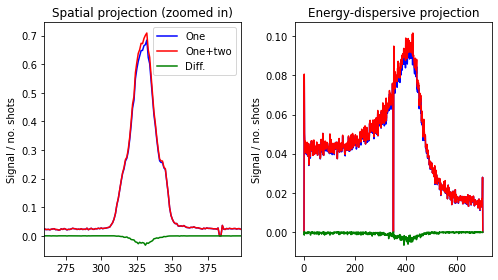

In [99]:
def create_img(x,y,adu,ndrop,adu_int,scale_signal):
    '''
    Create image with some ADU signals
    
    Call: img = create_img_v1(x,y,adu,ndrop,adu_interval,scale_signal)
    '''
    ind, = np.where((adu >= adu_int[0]) & (adu <= adu_int[1]))
    if scale_signal == True:    img, xedges, yedges = np.histogram2d(x[ind], y[ind], bins=[np.arange(705), np.arange(769)],weights=adu[ind])
    elif scale_signal == False:
        img_1ph, xedges, yedges = np.histogram2d(x[ind], y[ind], bins=[np.arange(705), np.arange(769)])
        ind, = np.where((adu >= 2.0*adu_int[0]) & (adu <= 2.0*adu_int[1]))
        img_2ph, xedges, yedges = np.histogram2d(x[ind], y[ind], bins=[np.arange(705), np.arange(769)])
        img = img_1ph + 2.0*img_2ph # scale 2-photon image by factor 2
    det_geom(img,'instruction')
    return img

plt.figure(figsize=(10,4))
img_1ph = create_img_v1(x,y,adu,ndrop,adu_xes,False)
img     = create_img(x,y,adu,ndrop,adu_xes,False)

plt.subplot(132); plt.title('Spatial projection (zoomed in)')
plt.plot(np.sum(img_1ph, axis=0)/len(ndrop),'b')
plt.plot(np.sum(img, axis=0)/len(ndrop),'r')
plt.plot(np.sum(img_1ph, axis=0)/len(ndrop)-np.sum(img, axis=0)/len(ndrop),'g')
plt.xlim((roi[2]-50,roi[3]+50))
plt.legend(('One','One+two','Diff.'))
plt.ylabel('Signal / no. shots')

plt.subplot(133); plt.title('Energy-dispersive projection')
plt.plot(np.sum(img_1ph, axis=1)/len(ndrop),'b')
plt.plot(np.sum(img, axis=1)/len(ndrop),'r')
plt.plot(np.sum(img_1ph, axis=1)/len(ndrop)-np.sum(img, axis=1)/len(ndrop),'g')
plt.ylabel('Signal / no. shots')

plt.tight_layout(); plt.show()

We see that including two-photon hits primarily affects the peak max region, as is to be expected. Discarding these hits will thus artificially flatten out the features.

## Tracking raw signal quality

We now form a function for traking the (XES) signal quality:

Looking at runs 1-1 from expt 'instruction', with 7.77e+03 shots and 1.58e+06 droplets.


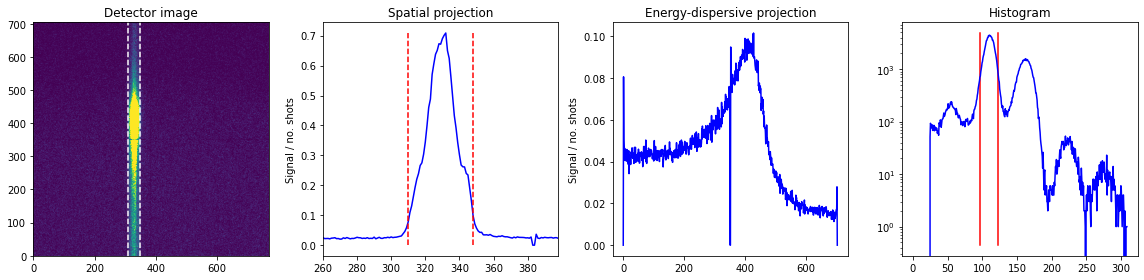

In [174]:
def plot_raw(runs,roi,adu_int,plot_results,bt):
    '''
    Plot histogram, detector image, and projections
    Can include an ROI or do this over full image
    
    Call: spat_spec,xes_spec = plot_raw(runs,roi,adu_int,plot_results,bt)
    '''
    x,y,adu,ndrop,gmd = load_runs(runs,bt)
    print('Looking at runs {}-{} from expt \'{}\', with {:.2e} shots and {:.2e} droplets.'.format(runs[0],runs[len(runs)-1],bt,len(ndrop),sum(ndrop)))
    img = create_img(x,y,adu,ndrop,adu_int,False)
    spat_spec = np.sum(img, axis=0)/len(ndrop)
    xes_spec  = np.sum(img, axis=1)/len(ndrop)
    
    if plot_results == True:
        plt.figure(figsize=(16,4))
        plt.subplot(141); plt.title('Detector image')
        vmin, vmax = np.percentile(img, [1, 99])
        plt.imshow(img, origin='lower',vmin=vmin, vmax=vmax,aspect='auto')
        if roi != False:
            plt.plot([roi[2],roi[2]],[roi[0],roi[1]],'w--')
            plt.plot([roi[3],roi[3]],[roi[0],roi[1]],'w--')
            plt.xlim((0,len(img[0]))); plt.ylim((0,len(img)))
        plt.subplot(142); plt.title('Spatial projection')
        plt.plot(spat_spec,'b')
        plt.plot([roi[2],roi[2]],[0,max(np.sum(img, axis=0)/len(ndrop))],'r--')
        plt.plot([roi[3],roi[3]],[0,max(np.sum(img, axis=0)/len(ndrop))],'r--')
        plt.xlim((roi[2]-50,roi[3]+50))
        plt.ylabel('Signal / no. shots')
        plt.subplot(143); plt.title('Energy-dispersive projection')
        plt.plot(xes_spec,'b')
        plt.ylabel('Signal / no. shots')
        plt.subplot(144); plt.title('Histogram')
        ind, = np.where((y >= roi[2]) & (y <= roi[3]))
        p = np.percentile(adu[ind], 99.9) # 99.9th percentile, for xmax
        hist, bin_edges = np.histogram(adu[ind],bins = np.arange(0,p,p/500.))
        ylims = [0.0001*np.max(hist),1.1*np.max(hist)]
        plt.plot([adu_int[0],adu_int[0]],ylims,'-',color='r')
        plt.plot([adu_int[1],adu_int[1]],ylims,'-',color='r')
        plt.plot(bin_edges[1:]-0.5,hist,'b'); plt.yscale('log')
        plt.tight_layout()
    return spat_spec,xes_spec
    
adu_int = [97.0,123.0]
spat_spec,xes_spec = plot_raw([1],roi,adu_int,True,bt)
plt.show()

This can now be used to track the focus and signal-to-noise ratio over different runs, or looking at combined runs:

Looking at runs 1-1 from expt 'instruction', with 7.77e+03 shots and 1.58e+06 droplets.
Looking at runs 2-2 from expt 'instruction', with 1.11e+04 shots and 3.07e+06 droplets.
Looking at runs 3-3 from expt 'instruction', with 8.67e+03 shots and 1.95e+06 droplets.
Looking at runs 4-4 from expt 'instruction', with 1.08e+04 shots and 2.47e+06 droplets.
Looking at runs 5-5 from expt 'instruction', with 1.08e+04 shots and 2.77e+06 droplets.
Looking at runs 6-6 from expt 'instruction', with 1.41e+04 shots and 3.31e+06 droplets.


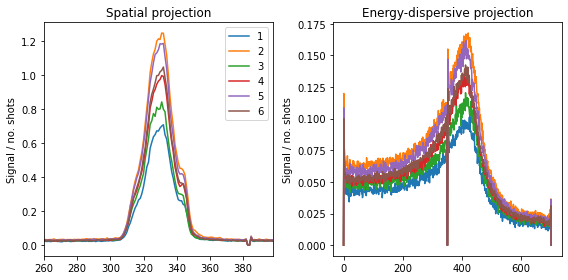

Looking at runs 1-6 from expt 'instruction', with 6.33e+04 shots and 1.52e+07 droplets.


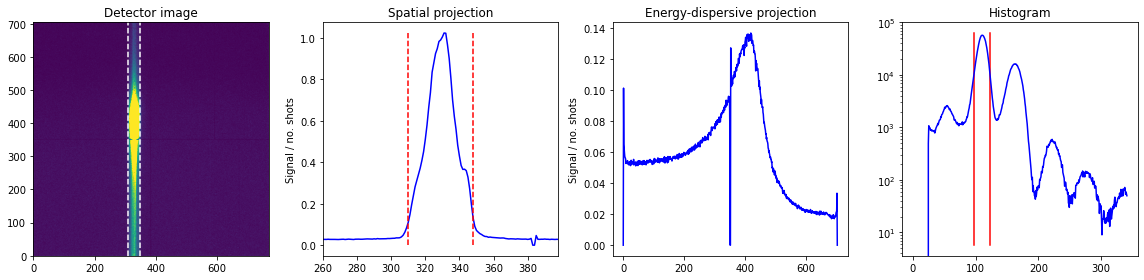

In [175]:
runs = [1,2,3,4,5,6]
plt.figure(figsize=(8,4))
ax0 = plt.subplot(121); plt.title('Spatial projection')
ax1 = plt.subplot(122); plt.title('Energy-dispersive projection')
for run in runs:
    spat_spec,xes_spec = plot_raw([run],roi,adu_int,False,bt)
    ax0.plot(spat_spec)
    ax1.plot(xes_spec)
    
ax0.set_xlim((roi[2]-50,roi[3]+50))
ax0.legend((runs))
ax0.set_ylabel('Signal / no. shots')
ax1.set_ylabel('Signal / no. shots')
plt.tight_layout(); plt.show()

spat_spec,xes_spec = plot_raw(runs,roi,adu_int,True,bt)
plt.show()

We clearly see the difference in signal between the different runs.

The functions defined and used here are now enclosed in the 'xest.py' file, and will be called and for subsequent notebooks.